# **Understand and Inspect the Dataset for Fat Tails**

### Visual analysis

date_id              0
time_id              0
symbol_id            0
weight               0
feature_00     1944210
                ...   
responder_4          0
responder_5          0
responder_6          0
responder_7          0
responder_8          0
Length: 92, dtype: int64


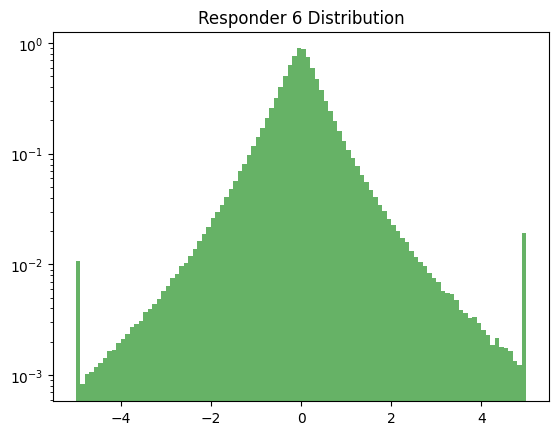

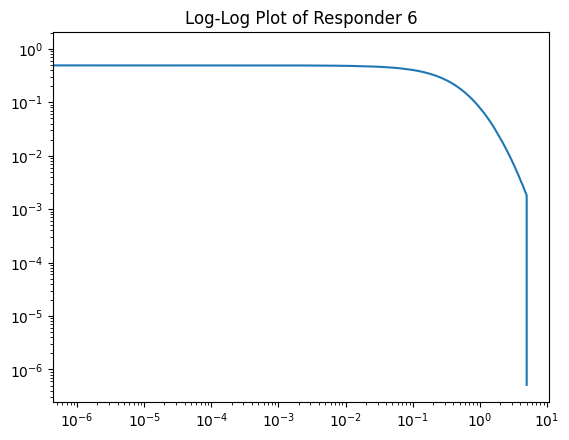

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/JaneStreetKaggleCompetition/data/raw/train/partition_id=0/part-0.parquet')
# df = pd.read_parquet('/drive/MyDrive/Colab Notebooks/JaneStreetKaggleCompetition/data/raw/train/partition_id=0/part-0.parquet')

# Check for missing values
print(df.isnull().sum())

responder = df['responder_6']
plt.hist(responder, bins=100, density=True, alpha=0.6, color='g')
plt.title('Responder 6 Distribution')
plt.yscale('log')  # Log scale to inspect fat tails
plt.show()

# Log-log plot for tail
sorted_responder = np.sort(responder)
plt.loglog(sorted_responder, np.arange(len(sorted_responder), 0, -1) / len(sorted_responder))
plt.title('Log-Log Plot of Responder 6')
plt.show()


**Responder 6 Distribution (Linear Plot):**

  Responder 6 is approximatly symmetric aroung 0.

  The distribution is not normal (Gaussian). Its sharp peak and long tails are indicative of fat tails, a common characteristic in financial data.

**Log-Log Plot:**

  The straight part in the middle suggests that the tail behavior might follow a power law, which aligns with your calculation of the tail index (α = 2.26)
  
  Fat-tailed distributions indicate that extreme events (large positive or negative values) occur more often than they would in a Gaussian distribution.

### Statistical

In [2]:
from scipy.stats import kurtosis

# Kurtosis for responder_6
kurt = kurtosis(responder, fisher=True)
print(f'Kurtosis of Responder 6: {kurt}')

# Hill estimator
def hill_estimator(data, threshold_percentile=95):
    threshold = np.percentile(data, threshold_percentile)
    tail_data = data[data > threshold]
    alpha = len(tail_data) / np.sum(np.log(tail_data / threshold))
    return alpha

alpha = hill_estimator(responder)
print(f'Tail index (alpha): {alpha}')


Kurtosis of Responder 6: 6.820833450753845
Tail index (alpha): 2.2578235814034424


**Interpreting Statistical Indicators**

Kurtosis=6.82 (greater than 3): This indicates the presence of **leptokurtic behavior**, meaning the distribution has heavier tails and a sharper peak than a normal distribution. This aligns with the visual evidence of fat tails.

α=2.26: A tail index between 2 and 3 suggests that the distribution has finite variance (but potentially infinite higher moments, such as skewness). This further confirms the fat-tailed nature of the data.

Tail index estimation is critical for understanding the risk of extreme values in financial markets.


In [3]:
# Calculate statistics
print("Mean:", df['responder_6'].mean())
print("Variance:", df['responder_6'].var())
print("Skewness:", df['responder_6'].skew())
print("Kurtosis:", kurtosis(df['responder_6']))

Mean: 0.0014876343
Variance: 0.7563174366950989
Skewness: 0.29999408
Kurtosis: 6.820833450753845


In [4]:
%cd drive/MyDrive/Colab \Notebooks/JaneStreetKaggleCompetition
# %pwd
# !git status
# !git init
# !git status
# !git rm --cached data/raw
# !cat .gitignore
# !echo "data/raw" >> .gitignore


/content/drive/MyDrive/Colab Notebooks/JaneStreetKaggleCompetition


In [ ]:

# import os
# import pandas as pd

# # Path to the root directory containing the partitions
# root_dir = os.path.join("data", "raw", "train")  # Update with your actual path

# # List to store DataFrames
# dataframes = []

# # Iterate through the directories
# for partition_dir in sorted(os.listdir(root_dir)):
#     full_path = os.path.join(root_dir, partition_dir)

#     # Check if the directory contains .parquet files
#     if os.path.isdir(full_path):
#         for file in os.listdir(full_path):
#             if file.endswith(".parquet"):
#                 file_path = os.path.join(full_path, file)
#                 print(f"Reading file: {file_path}")

#                 # Read the .parquet file and append it to the list
#                 df = pd.read_parquet(file_path)
#                 dataframes.append(df)

# # Combine all DataFrames into one
# combined_df = pd.concat(dataframes, ignore_index=True)

# # Save the combined DataFrame as a single .parquet file
# output_path = "/data/processed/combined_train_data.parquet"  # Update with your desired output path
# combined_df.to_parquet(output_path, index=False)

# print(f"Combined data saved to {output_path}")


Reading file: data/raw/train/partition_id=0/part-0.parquet
Reading file: data/raw/train/partition_id=1/part-0.parquet
Reading file: data/raw/train/partition_id=2/part-0.parquet
Reading file: data/raw/train/partition_id=3/part-0.parquet
Reading file: data/raw/train/partition_id=4/part-0.parquet
Reading file: data/raw/train/partition_id=5/part-0.parquet
Reading file: data/raw/train/partition_id=6/part-0.parquet


In [5]:
import os
import pandas as pd

# Path to the root directory containing the partitions
root_dir = os.path.join("data", "raw", "train")  # Update with your actual path
output_path = os.path.join("data", "processed", "combined_train_data.parquet")  # Update with your desired output path

# Create the output directory if it doesn't exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Use a generator to process files one by one
def read_partitions(root_dir):
    for partition_dir in sorted(os.listdir(root_dir)):
        full_path = os.path.join(root_dir, partition_dir)
        if os.path.isdir(full_path):
            for file in os.listdir(full_path):
                if file.endswith(".parquet"):
                    file_path = os.path.join(full_path, file)
                    print(f"Reading file: {file_path}")
                    try:
                        # Yield each DataFrame
                        yield pd.read_parquet(file_path)
                    except Exception as e:
                        print(f"Error reading file {file_path}: {e}")
                        continue

# Process and write the combined data incrementally
with pd.option_context("mode.chained_assignment", None):  # Suppress warnings for performance
    for i, df_chunk in enumerate(read_partitions(root_dir)):
        if i == 0:
          print(f"Writing to file: {output_path}")
          df_chunk.to_parquet(output_path, index=False)
        else:
          print(f"Appending to file: {output_path}")

Reading file: data/raw/train/partition_id=0/part-0.parquet
Writing to file: data/processed/combined_train_data.parquet
Reading file: data/raw/train/partition_id=1/part-0.parquet
Appending to file: data/processed/combined_train_data.parquet
Reading file: data/raw/train/partition_id=2/part-0.parquet
Appending to file: data/processed/combined_train_data.parquet
Reading file: data/raw/train/partition_id=3/part-0.parquet
Appending to file: data/processed/combined_train_data.parquet
Reading file: data/raw/train/partition_id=4/part-0.parquet
Appending to file: data/processed/combined_train_data.parquet
Reading file: data/raw/train/partition_id=5/part-0.parquet
Appending to file: data/processed/combined_train_data.parquet
Reading file: data/raw/train/partition_id=6/part-0.parquet
Appending to file: data/processed/combined_train_data.parquet
Reading file: data/raw/train/partition_id=7/part-0.parquet
Appending to file: data/processed/combined_train_data.parquet
Reading file: data/raw/train/parti

In [ ]:
lagged = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/JaneStreetKaggleCompetition/data/raw/lags.parquet/date_id=0/part-0.parquet')
print(lagged.head())
lagged.columns


In [6]:
!python src/preprocess.py

Preprocessing data...
Loading training data...
Step 1: Dropping empty or constant columns...
Dropping 18 columns
Step 2: Handling missing values...
Imputing missing values in feature_08
Imputing missing values in feature_15
Imputing missing values in feature_16
Imputing missing values in feature_17
Imputing missing values in feature_18
Imputing missing values in feature_19
Imputing missing values in feature_32
Imputing missing values in feature_33
Imputing missing values in feature_39
Imputing missing values in feature_40
Imputing missing values in feature_41
Imputing missing values in feature_42
Imputing missing values in feature_43
Imputing missing values in feature_44
Imputing missing values in feature_45
Imputing missing values in feature_46
Imputing missing values in feature_47
Imputing missing values in feature_50
Imputing missing values in feature_51
Imputing missing values in feature_52
Imputing missing values in feature_53
Imputing missing values in feature_54
Imputing missing

In [9]:
!python src/feature_engineering.py

Loading training data...
Step 1: Adding custom lags...
Step 2: Adding rolling features...
Step 3: Adding cyclical features...
Step 4: Standardizing features...
Step 5: Normalizing features...
Step 6: Adding lag aggregates...
Step 7: Adding EMA features...
Step 8: Adding time features...
Step 9: Quantile transforming features...
Step 10: Saving engineered data...
Engineered train data saved to data/processed/train_engineered.parquet


In [12]:
# Load data
dataframe = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/JaneStreetKaggleCompetition/data/processed/train_engineered.parquet')

dataframe.head()
print(dataframe.shape)
print(dataframe.columns)


(1944210, 267)
Index(['date_id', 'time_id', 'symbol_id', 'weight', 'feature_00', 'feature_01',
       'feature_02', 'feature_03', 'feature_04', 'feature_05',
       ...
       'is_weekend', 'responder_0_quantile', 'responder_1_quantile',
       'responder_2_quantile', 'responder_3_quantile', 'responder_4_quantile',
       'responder_5_quantile', 'responder_6_quantile', 'responder_7_quantile',
       'responder_8_quantile'],
      dtype='object', length=267)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
corr = dataframe.corr()
plt.figure(figsize=(100, 80))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
dataframe.columns

In [13]:
# Group by date_id
daily_mean = dataframe.groupby('date_id')['responder_6'].mean()
plt.plot(daily_mean)
plt.title('Daily Mean of Responder 6')
plt.xlabel('Date')
plt.ylabel('Responder 6')

NameError: name 'plt' is not defined

In [1]:
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Lag plot
lag_plot(dataframe['responder_6'])

# ACF and PACF
plot_acf(dataframe['responder_6'], lags=50)
plot_pacf(dataframe['responder_6'], lags=50)

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.01)  # 1% anomalies
dataframe['anomaly'] = iso.fit_predict(dataframe[['responder_6']])